# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy

# Preparation des données

## Importation

In [2]:
data_real = pd.read_csv('./data.csv', sep=";")

## Affichage

In [3]:
#  Séléectionner les bonnes colonnes
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
# print(data)
# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

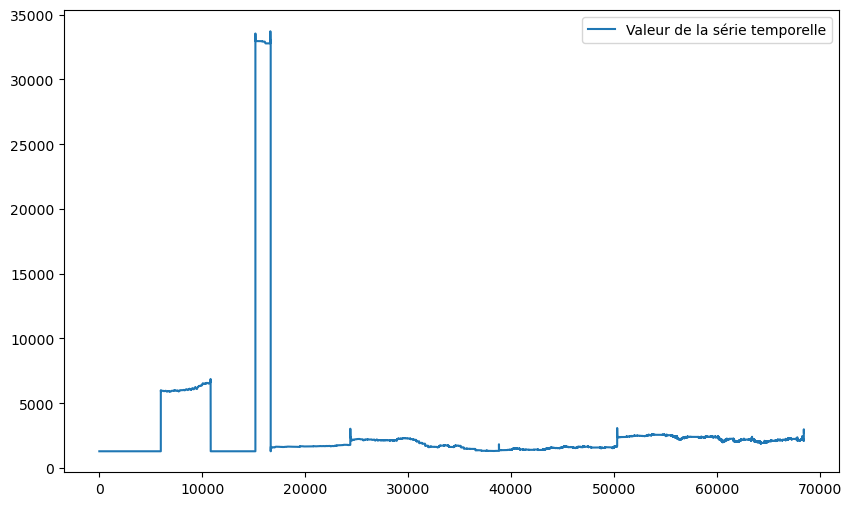

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues.

Sur le début de la plage de données, on observe des paliers de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur d'autres valeurs:

1) entre 0 et 10 000 on a un pic qui passe de 1 280 à environ 6 500
2) entre 15 000 et 20 000 on a un pic qui passe de 1 280 à 32 770

Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

On sélectionne seulement la partie du signal qui nous intéresse

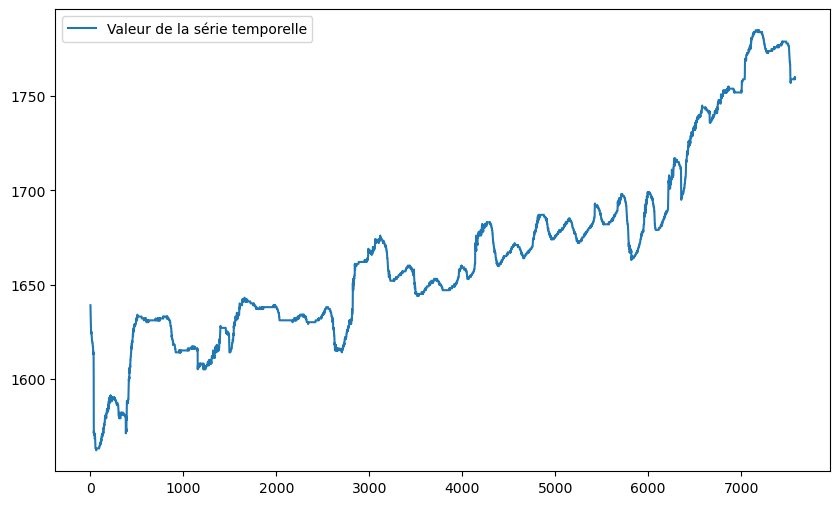

In [5]:
# D'après la base de donnée on obtient cet indice
data_crop = data[16656:24236,2 ] 

# Transformation en série temporelle
time_serie_crop = pd.Series(data_crop, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On regarde quel est le pas de temps entre chaque prise de données

In [6]:
from datetime import datetime

# Exemple de données
data_time = data_real.iloc[16656:24236, 1].to_numpy()

# Conversion en objets datetime
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Calcul des différences en minutes
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

# Affichage des résultats
print("Différences en minutes entre chaque données :")
print(np.unique(differences_minutes))


Différences en minutes entre chaque données :
[5.]


## Detection des discontinuités

In [7]:
def detect_pic(data, seuil=100):
    pic_indices = []
    offset_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(data) - 2):
        
        # on regarde si la différence entre les 2 valeurs est plus grande en valeur absolue que le seuil
        if np.abs(data[i] - data[i+1]) >= seuil :
            # si le saut suivant est aussi supérieur à un pic alors ceci est une valeur aberrante
            if np.abs(data[i+1] - data[i+2]) >= seuil : 
                pic_indices.append(i+1) 
            # sinon on considère qu'il y a un problème d'offset
            else : 
                offset_indices.append(i+1) 
        
    return pic_indices, offset_indices

In [8]:
pic, offset = detect_pic(data_crop)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_crop[pic])

Nombre de pics détectés : 0
Nombre d'offset détectés : 0
Indices des pics : []
Indices des offset : []
Valeurs des pics : []


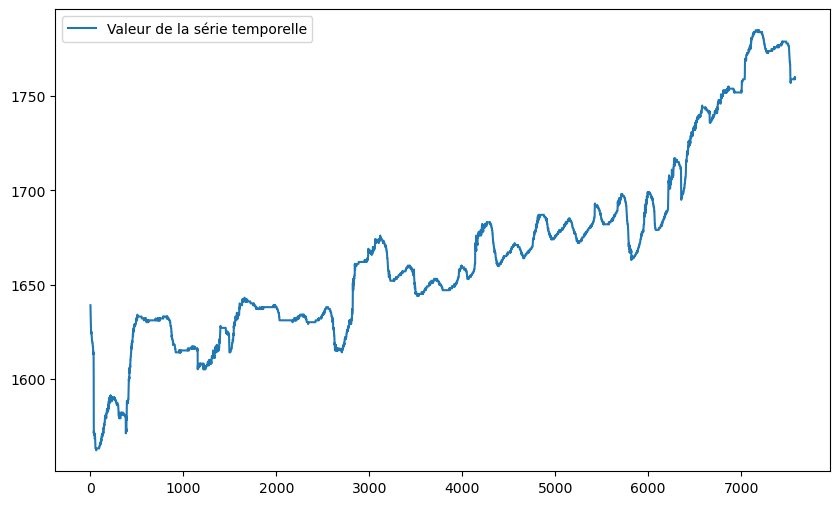

In [9]:
# Affichage des pics sur notre série temporelle pour vérifier si c'est cohérent 

plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')

# Ajout des barres verticales correspondant aux pics
for i,x in enumerate(pic):
    if i == 0:
        plt.axvline(x=x, color='red', linestyle='--', label='Valeur des pics')
    else:
        plt.axvline(x=x, color='red', linestyle='--')

plt.legend(loc='upper left')
plt.show()

In [10]:
data_clean = data_crop

In [11]:
# Valeur des offset
data_diff = []
data_offset = []
k = 0
for i in range(0,len(data_clean)-1):
    data_diff.append(data_clean[i+1]-data_clean[i])
    if i == offset[k] : 
        data_offset.append(data_clean[i]-data_clean[i-1])
        if k < len(offset) -1 :
            k += 1
    else : 
        data_offset.append(0)
    
   
# Transformation en série temporelle
time_serie_diff = pd.Series(data_diff, dtype='float64')
time_serie_offset = pd.Series(data_offset, dtype='float64')

# Affichage de la série diff
plt.figure(figsize=(10, 6))
plt.plot(time_serie_diff, label='Valeur des différences en chaque point')
plt.legend()
plt.show()

# Affichage de la série offset
plt.figure(figsize=(10, 6))
plt.plot(time_serie_offset, label='Valeur des offset')
plt.legend()
plt.show()

IndexError: list index out of range

## Suppression de l'offset

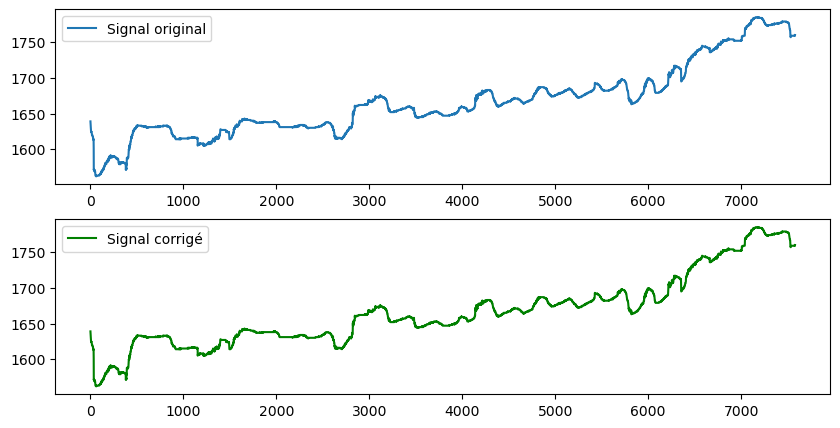

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 50

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

# Correction du signal
data_ajust = data_clean.copy()
for saut in sauts:
    # Ajuster les valeurs après le saut en supprimant l'offset
    offset = data_ajust[saut+1] - data_ajust[saut]
    data_ajust[saut+1:] -= offset

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_ajust, label="Signal corrigé", color='green')
plt.legend()
plt.show()


On a supprimé les pics et l'offset en "recollant" les données aartificiellement

# Décomposition spéctrale

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

In [13]:
def freq_to_day (freq) :
    return (1/freq)/(60*24*24)

Période ayant la plus grande amplitude 2.2689176245210727 j


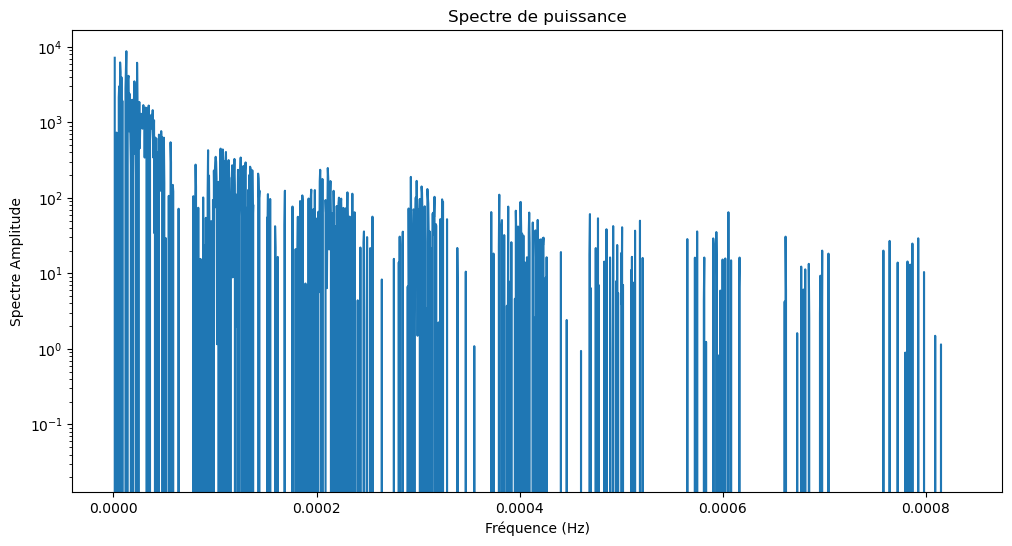

In [14]:
amplitudes = np.real(np.fft.rfft(data_ajust))[3:] # Les 2 premières sont bizarres
frequencies = np.fft.rfftfreq(len(data_ajust),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2], label='Spectre original')
# Affichage du spectre avec les amplitudes moyennes par bloc
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies[np.argmax(amplitudes)]),"j" )

On observe sur ce signal que :
- La fréquence correspondante au cycle diurne n'est pas captée
- Nous n'avons pas une fréquence et des harmoniques mais des agglomérats autour des fréquences de références

Nous allons donc moyenner les fréquences pour obtenir qu'une seule fréquence par agglomérat

In [15]:
def average_by_chunk(frequencies, amplitudes, chunk_size=50):
    # Calcul du nombre de blocs
    num_chunks = len(frequencies) // chunk_size
    avg_frequencies = []
    avg_amplitudes = []
    
    # Diviser en blocs et calculer la moyenne
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        # Sélectionner les indices du bloc
        chunk_frequencies = frequencies[start_idx:end_idx]
        chunk_amplitudes = amplitudes[start_idx:end_idx]
        
        # Calculer la fréquence moyenne (c'est la fréquence du centre du bloc)
        avg_frequency = np.mean(chunk_frequencies)
        
        # Calculer l'amplitude moyenne du bloc
        avg_amplitude = np.mean(chunk_amplitudes)
        
        avg_frequencies.append(avg_frequency)
        avg_amplitudes.append(avg_amplitude)
    
    return np.array(avg_frequencies), np.array(avg_amplitudes)


Période ayant la plus grande amplitude 1.3852339181286548 j avec chunk = 90
Période ayant la plus grande amplitude 1.0527777777777778 j avec chunk = 120


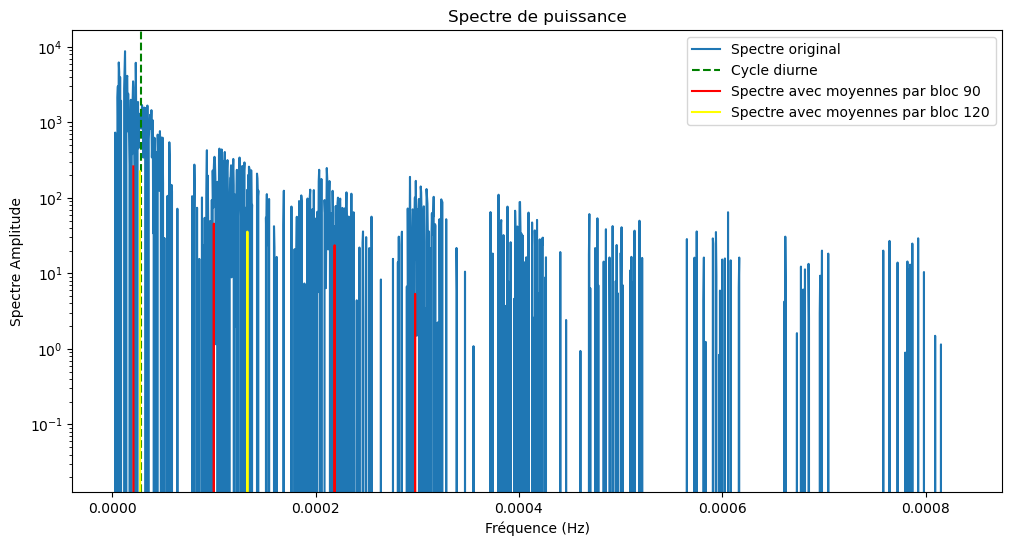

In [16]:


plt.figure(figsize=(12, 6))
plt.semilogy((frequencies[3:len(frequencies)//2]), amplitudes[3:len(amplitudes)//2], label='Spectre original')
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')

chunk_size = 90
frequencies_avg, amplitudes_avg = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg[:len(frequencies_avg)//2], amplitudes_avg[:len(frequencies_avg)//2],  label='Spectre avec moyennes par bloc 90', color='red')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg[np.argmax(amplitudes_avg)]),"j avec chunk =", chunk_size )

chunk_size = 120
frequencies_avg, amplitudes_avg = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg[:len(frequencies_avg)//2], amplitudes_avg[:len(frequencies_avg)//2],  label='Spectre avec moyennes par bloc 120', color='yellow')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg[np.argmax(amplitudes_avg)]),"j avec chunk =", chunk_size )

# Affichage du spectre avec les amplitudes moyennes par bloc
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()


Le résutlat proposé est beaucoup plus pertinent mais n'est toujours pas très robuste car il dépend énormément de la taille de chunk que nous proposons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Amplitude')

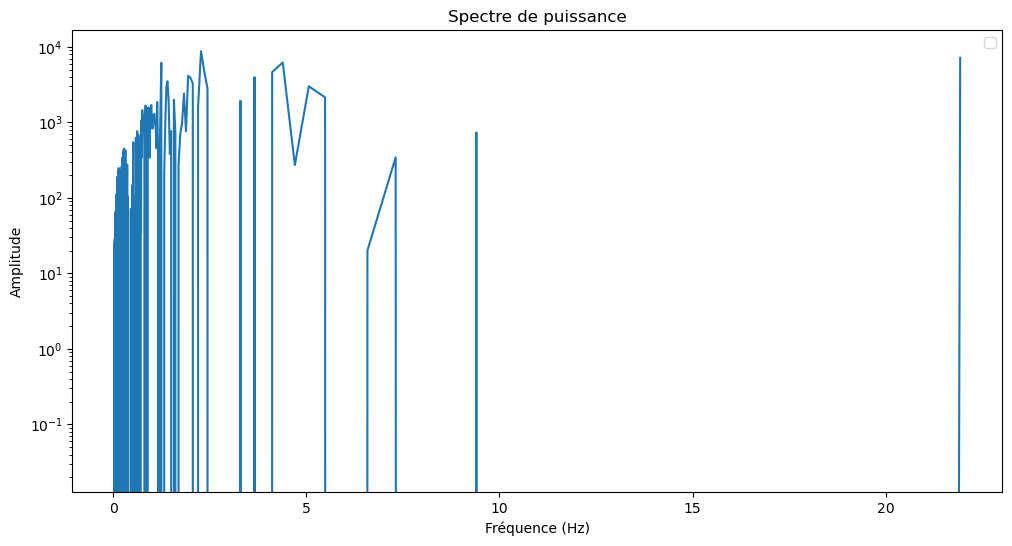

In [18]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points

# Transformée de Fourier du signal
signal_fft = np.fft.rfft(data_ajust)[3:] # rfft car signal à valeurs réelles
frequences = np.fft.rfftfreq(N, T) # retourne sous forme de complexes
amplitudes = np.real(signal_fft) # on prend la partie réelle


# Affichage
plt.figure(figsize=(12, 6))
plt.semilogy(freq_to_day(frequencies[:len(frequencies)//2]), amplitudes[:len(amplitudes)//2])


# utile pour la suite

plt.legend()

plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

In [19]:
# Détection des pics dans le spectre d'amplitude
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.1)  # Seulement les pics significatifs

# Première fréquence dominante
frequence_principale = frequences[peaks[0]] 
periode_principale = 1 / frequence_principale 
print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 175.90150 1e-8 Hz, soit une période d'environ 6.58 jours


Le résultat attendu n'est pas bon, cela ne correspond à aucune saisonnalité explicable

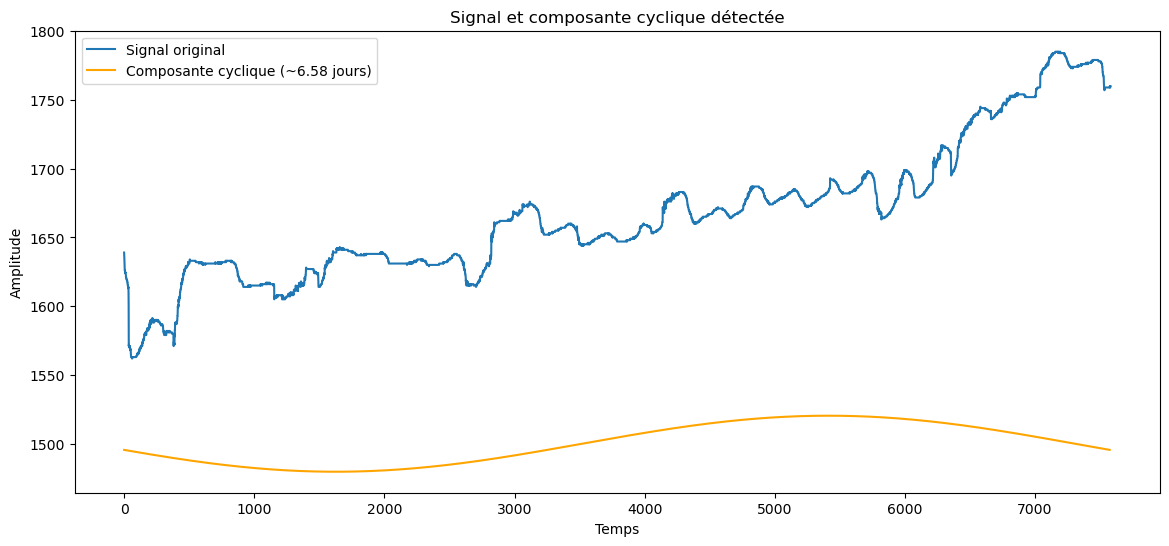

In [21]:
# Filtrage autour de la fréquence dominante
largeur_bande = frequence_principale / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale) < largeur_bande)[3:]

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft = signal_fft * filtre_cyclique
signal_cyclique = np.fft.irfft(signal_cyclique_fft)


# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_cyclique.real+1500, label=f"Composante cyclique (~{periode_principale / (3600*24):.2f} jours)", color="orange")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

### Reconstruire le signal avec les fréquences principales

In [23]:
signal_rec = np.zeros(len(data_ajust))
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 8) 
for p in peaks :
    largeur_bande = frequences[p] / 100  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
    filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequences[p]) < largeur_bande)[3:]

    # Appliquer le filtre pour isoler la composante cyclique
    signal_cyclique_fft = signal_fft * filtre_cyclique
    signal_cyclique = np.fft.irfft(signal_cyclique_fft)
    signal_rec += signal_cyclique

plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_rec, label="Signal reconstitué ")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (7580,) (7574,) (7580,) 

## Densité spectrale Welch

In [ ]:
# pip install --upgrade scipy

In [25]:
from scipy.signal import welch

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation de la méthode de Welch
def welch_manual(data, fs, nperseg, noverlap=None):
    # Taille du signal
    n = len(data)
    
    # Calcul de l'overlap
    if noverlap is None:
        noverlap = nperseg // 2
    
    # Nombre de segments
    nsegments = (n - nperseg) // (nperseg - noverlap) + 1
    
    # Fréquences de la FFT
    freqs = np.fft.fftfreq(nperseg, d=1/fs)
    freqs = freqs[:nperseg//2]  # On ne garde que les fréquences positives
    
    # Densité spectrale de puissance
    psd = np.zeros(len(freqs))
    
    for i in range(nsegments):
        # Indices de début et de fin de chaque segment
        start = i * (nperseg - noverlap)
        end = start + nperseg
        
        # Segment du signal
        segment = data[start:end]
        
        # FFT du segment
        fft_segment = np.fft.fft(segment)
        
        # Calcul de la puissance (module au carré de la FFT)
        psd_segment = np.abs(fft_segment[:nperseg//2])**2
        
        # Moyenne des PSDs sur les segments
        psd += psd_segment
    
    psd /= nsegments  # Moyenne sur les segments
    
    return freqs, psd

/tmp/ipykernel_26897/303370147.py:40: RuntimeWarning: invalid value encountered in divide
  psd /= nsegments  # Moyenne sur les segments
/usr/local/insa/anaconda/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 8192 is greater than input length  = 7580, using nperseg = 7580
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


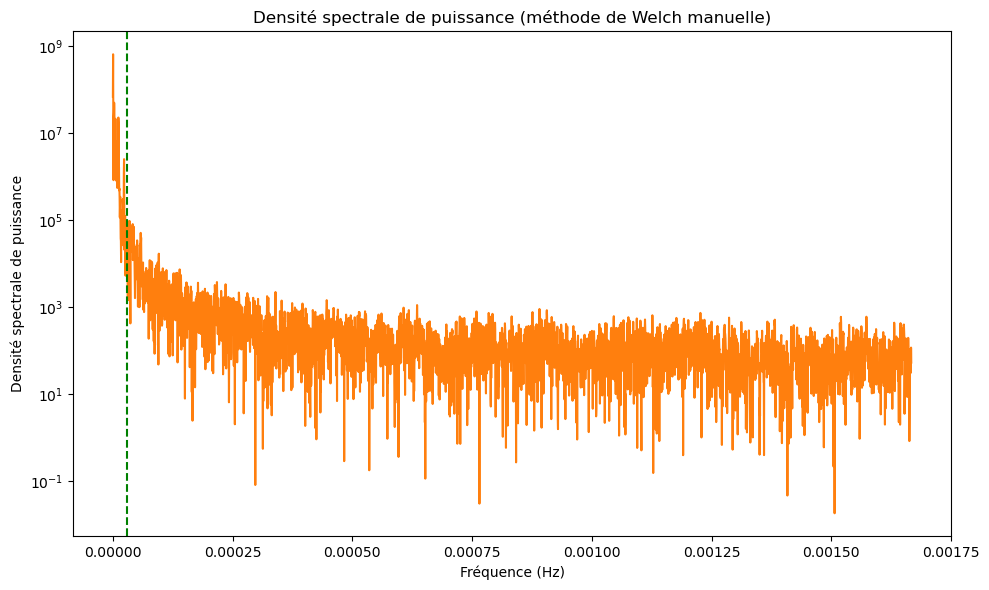

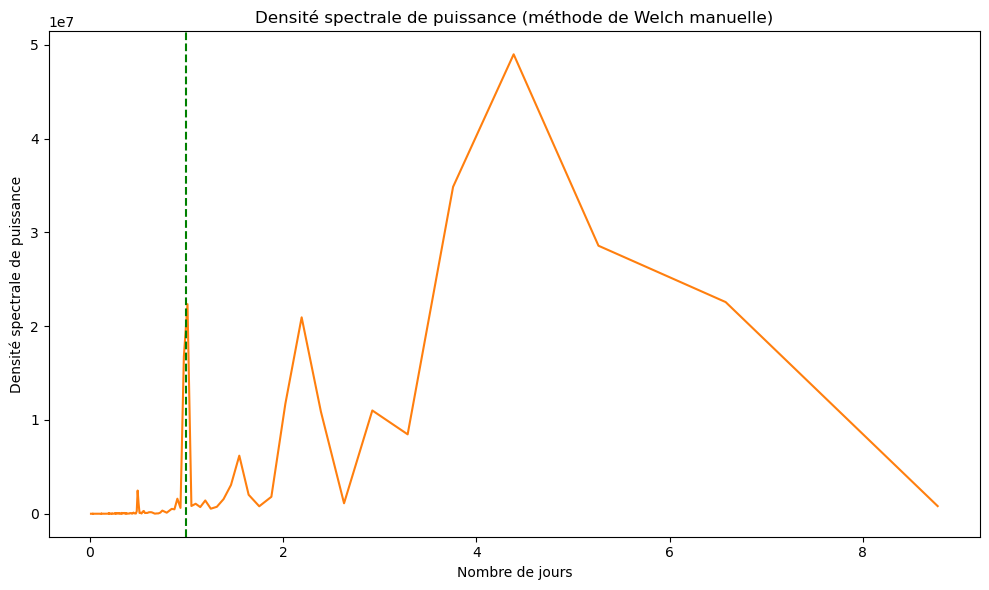

In [48]:
 #Paramètres de la méthode de Welch
nperseg = 8192 # 288
noverlap = int(nperseg/5)
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_manual, psd_manual = welch_manual(data_ajust, fs, nperseg, noverlap)
frequencies_auto, psd_auto = welch(data_ajust, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_manual, psd_manual)
plt.semilogy(frequencies_auto, np.abs(psd_auto))
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(((1/frequencies_manual[3:len(frequencies_manual)//2])/(60*60*24)), psd_manual[3:len(psd_manual)//2])
plt.plot(((1/frequencies_auto[3:len(frequencies_auto)//2])/(60*60*24)), np.abs(psd_auto[3:len(psd_auto)//2]))
plt.axvline(x=1, color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Nombre de jours')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()


In [49]:
top_3_indices = np.argsort(np.abs(psd_auto))[-20:][::-1]

print(top_3_indices)

# Afficher les indices et les fréquences correspondantes
results = []
for i, index in enumerate(top_3_indices):
    max_psd_frequency_m = frequencies_auto[index]
    result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule
    results.append(result)
    print(f"Valeur #{i+1} : fréquence = {max_psd_frequency_m}, résultat = {result} jours")
##

max_psd_index_a = np.argmax(np.abs(psd_auto))
print(max_psd_index_a)
max_psd_frequency_a = frequencies_auto[max_psd_index_a]
print(max_psd_frequency_a)

max_psd_index_m = np.argmax(np.abs(psd_manual))
print(max_psd_index_m)
max_psd_frequency_m = frequencies_manual[max_psd_index_m+1]
print(max_psd_frequency_m)


# Afficher la fréquence avec la plus grande PSD
print(f"Fréquence avec la plus grande PSD en manuel : {(1/max_psd_frequency_m)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD en auto : {(1/max_psd_frequency_a)/(60*60*24)} j")

[ 1  0  6  7  5  4 26 12 27  2 13  9 11  8 17 18 53 16 14 29]
Valeur #1 : fréquence = 4.3975373790677223e-07, résultat = 26.319444444444443 jours
Valeur #2 : fréquence = 0.0, résultat = inf jours
Valeur #3 : fréquence = 2.6385224274406333e-06, résultat = 4.386574074074074 jours
Valeur #4 : fréquence = 3.0782761653474056e-06, résultat = 3.759920634920635 jours
Valeur #5 : fréquence = 2.198768689533861e-06, résultat = 5.263888888888889 jours
Valeur #6 : fréquence = 1.759014951627089e-06, résultat = 6.579861111111111 jours
Valeur #7 : fréquence = 1.1433597185576078e-05, résultat = 1.0122863247863247 jours
Valeur #8 : fréquence = 5.2770448548812665e-06, résultat = 2.193287037037037 jours
Valeur #9 : fréquence = 1.187335092348285e-05, résultat = 0.9747942386831275 jours
Valeur #10 : fréquence = 8.795074758135445e-07, résultat = 13.159722222222221 jours
Valeur #11 : fréquence = 5.716798592788039e-06, résultat = 2.0245726495726495 jours
Valeur #12 : fréquence = 3.95778364116095e-06, résultat 

/tmp/ipykernel_26897/2915299488.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule


Explication :

Il doit exister une composante cyclique au delà de notre domaine d'étude ( 1 an ? ). C'est pour cela qu'à chaque fois que l'on augmente nperseg, on affine notre précision spectrale, permettant d'attraper des fréquences plus petite ( donc des périodes plus longues). En fait la fréquence principales correspond à ce que Welch a pu comprendre de ce fameux cycle annuel ( d'où la plus grande fréquence possible à chaque fois). Ensuite si l'on affiche les autres fréquences importantes on voit qu'il y a les fréquences proches de la fréquences principales. Celles-ci ne sont pas représentatives mais on été artificiellement grossi par le spectral leakage. Cependant la prochaine fréquence intéressante qui apparait "d'elle même" est celle correspondant à 1j ( modulo les virgules du à la précision spectrale ). Cela confirme bien qu'une des composantes principales est le cycle diurne

Que l'on fasse Welch avec la fonction déjà implémentée ou Welch à la main, on trouve la même fréquence principale. Ce qui démontre la cohérence "sémantique". Toutefois le résultats obtenu n'est toujours pas celui attendu

1
6.510416666666667e-06
La plus basse fréquence principale est : 6.510416666666667e-06 Hz
Ca correspond à  : 1.7777777777777777 jours


/tmp/ipykernel_26897/138482483.py:44: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequencies/(60*60*24), np.abs(power_spectral_density), label="Densité spectrale")


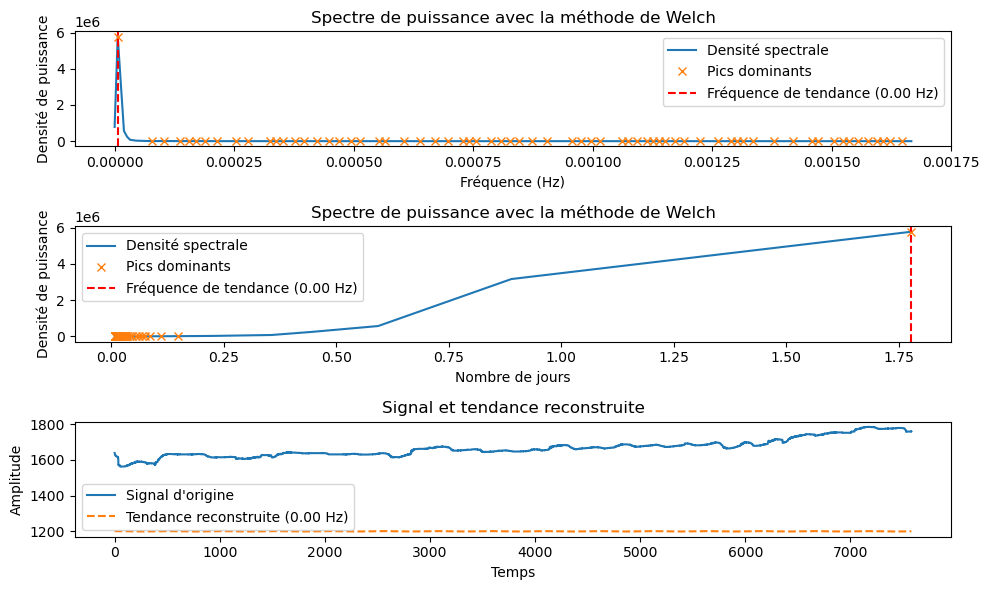

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.fft import ifft

signal = data_ajust  
T = 60*5 
fs = 1 / T  

# Décomposition spectrale de Welch
frequencies, power_spectral_density = welch(signal, fs=fs, nperseg=512, noverlap = 512/2)

# Identification des fréquences dominantes
peaks, _ = find_peaks(np.abs(power_spectral_density))
dominant_frequencies = frequencies[peaks]
dominant_powers = power_spectral_density[peaks]

# Recherche de la plus basse fréquence dominante
max_psd_index = np.argmax(np.abs(power_spectral_density))
print(max_psd_index)
max_psd_frequency = frequencies[max_psd_index]
print(max_psd_frequency)

print(f"La plus basse fréquence principale est : {max_psd_frequency} Hz")
print(f"Ca correspond à  : {(1/max_psd_frequency) /(60*60*24)} jours")

# Reconstruction de la tendance par filtrage
# On construit un signal harmonique avec la fréquence de tendance
t = np.arange(len(signal)) / fs
trend = np.cos(2 * np.pi * max_psd_frequency * t)

# Visualisation
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(frequencies, np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(dominant_frequencies, np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(max_psd_frequency, color='r', linestyle='--', label=f"Fréquence de tendance ({max_psd_frequency:.2f} Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(3, 1, 2)
plt.plot(1/frequencies/(60*60*24), np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(1/dominant_frequencies/(60*60*24), np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(1/max_psd_frequency/(60*60*24), color='r', linestyle='--', label=f"Fréquence de tendance ({max_psd_frequency:.2f} Hz)")
plt.xlabel("Nombre de jours")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(3, 1, 3)
plt.plot(signal, label="Signal d'origine")
plt.plot(trend+1200, label=f"Tendance reconstruite ({max_psd_frequency:.2f} Hz)", linestyle='--')
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Signal et tendance reconstruite")

plt.tight_layout()
plt.show()


# Série temporelle

### Modélisation avec la librairie STL

In [ ]:
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

data = pd.Series(data_ajust)

stl = STL(data, period=5*60, robust = True)
result = stl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(result.trend)
ax1.set_title('Trend')
ax2.plot(result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(result.resid)
ax3.set_title('Residual')
plt.tight_layout()
plt.show()

max_lag = 20000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

METTRE L'AUTOCORELATION AVEC DES BARRES ET NON UNE LIGNES CONTINUES

Les résidus ne présentent qu'un pic significatif au niveau de 0 : cela confirme que les résidus sont des bruits blancs

### Modélisation avec la librairie MSTL

In [ ]:
from statsmodels.tsa.seasonal import MSTL

data = pd.Series(data_ajust)

mstl = MSTL(data, periods=5*60)
result = mstl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(result.trend)
ax1.set_title('Trend')
ax2.plot(result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(result.resid)
ax3.set_title('Residual')
plt.tight_layout()
plt.show()

max_lag = 20000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Les résidus ne présentent qu'un pic significatif au niveau de 0 : cela confirme que les résidus sont des bruits blancs

### Modélisation avec seasonal_decompose

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(data, model='additive', period=60*5)
resid_valid = decomp.resid.dropna()

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

max_lag = 20000
acf_values = sm.tsa.acf(resid_valid, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

### Moyennes mobiles

In [ ]:
# Calculate rolling mean (adjust window to 96 for daily trends)
rolling_mean_d = data.rolling(window=24*12, center=True).mean()
rolling_mean_p = data.rolling(window=int(12*periode_principale/(3600*24)), center=True).mean()

# Calcul des résidus

daily = rolling_mean_d-data
princ = rolling_mean_p-data

# Calcul de l'autocorrélation
max_lag = 20000
acf_values_daily = sm.tsa.acf(daily.dropna(), nlags = max_lag)
acf_values_princ = sm.tsa.acf(princ.dropna(), nlags = max_lag)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

# Affichage des data
ax1.plot(data, label='Original Data', color='black', linewidth=2)
ax1.plot(rolling_mean_d, label='Trend journalière', color='gold', linewidth=2)
ax1.plot(rolling_mean_p, label='Trend de la fréquence principale', color='fuchsia', linewidth=2)
ax1.set_title('High-Frequency Time Series with Trend')

# Affichage des résidus
ax2.plot(daily, label='daily', color='gold', linewidth=2)
ax2.plot(princ, label='princ', color='fuchsia', linewidth=2)
ax2.set_title('Residuals')

# Affichage de l'autocorrélation
ax3.bar(range(max_lag + 1), acf_values_daily, color='gold')
ax3.bar(range(max_lag + 1), acf_values_princ, color='fuchsia')
ax3.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax3.axhline(y=0, color='red', label='Ligne à x=0')
ax3.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax3.set_title("Autocorrélation des résidus")
plt.legend()
plt.tight_layout()
plt.show()

### Modélisation à la main

#### Filtre passe-bas (Butterworth)

In [ ]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import butter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 6
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_ajust)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Les résidus présentent 2 pics significatifs : pas de bruits blancs

#### Filtre passe-bas (Savitzky-Golay)

In [ ]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import savgol_filter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 5
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
data_filtre = savgol_filter(data_ajust,10,2)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Les résidus présentent 2 pics significatifs : pas de bruits blancs

#### Lissage exponentiel

In [ ]:
import numpy as np

def lissage_exponentiel(data, alpha):
    """
    Applique un lissage exponentiel à une série de données.

    :param data: Liste ou array des données brutes.
    :param alpha: Coefficient de lissage (0 < alpha ≤ 1).
    :return: Array des valeurs lissées.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Le coefficient alpha doit être compris entre 0 et 1.")
    
    # Initialisation de la liste des valeurs lissées
    lissage = np.zeros_like(data, dtype=float)
    lissage[0] = data[0]  # La première valeur lissée est identique à la première donnée brute

    # Application du lissage exponentiel
    for t in range(1, len(data)):
        lissage[t] = alpha * data[t] + (1 - alpha) * lissage[t-1]
    
    return lissage


In [ ]:
# Calcul des données lissées et des résidus
alpha=0.01
lissage_resultat = lissage_exponentiel(data_ajust, alpha)
residus = data_ajust - lissage_resultat

# Tracé des résultats
plt.figure(figsize=(12, 6))

# Graphique des données brutes et lissées
# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(lissage_resultat, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 5))
plt.bar(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Les résidus ne présentent qu'un pics significatifs en 0 : bruit blanc

# Prédiction

In [ ]:
print(data.dtypes)  # Vérifiez que le type est numérique, comme float64 ou int64
data_num = pd.to_numeric(data, errors='coerce')  # Convertit tout en numérique
print(data_num.dtypes)

In [ ]:
from statsmodels.tsa.statespace.sarimax import *

m1 = SARIMAX(data_num, order=(1,1,1), seasonal_order=(1,1,1,24*12))
res1 = m1.fit(disp=False)
print(res1.summary())